# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
%cuda_context_handler gpu_ctx_refined

## Selecting loc

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [5]:
nk800_url  = ["/sintef/data/NorKyst800/ocean_his.an.20190716.nc"]

data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False))
data_args.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind'])

In [6]:
sim_args = {
    "dt": 0.0,
    "write_netcdf":False,
    "model_time_step": 60
     }

In [7]:
pert_args = {
    "small_scale_perturbation" : True,
    "small_scale_perturbation_interpolation_factor" : 21,
    "small_scale_perturbation_amplitude" : 0.00025
}

## Master Simulation

In [8]:
from gpuocean.SWEsimulators import CDKLM16

sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Child of Master

In [9]:
# [[y0,x0],[y1,x1]]
loc = [[100, 100], [200,300]]

scale = 1.2

In [10]:
sim.give_birth(gpu_ctx_refined, loc, scale)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Use halo mask according to bathymetry
Construct halo mask according to finer bathymetry information!


## Paired Simulations

In [12]:
# Prepare slave
slave = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [13]:
from gpuocean.SWEsimulators import CDKLM16pair

from importlib import reload
reload(CDKLM16pair)

<module 'gpuocean.SWEsimulators.CDKLM16pair' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16pair.py'>

In [14]:
sim_pair = CDKLM16pair.CDKLM16pair(sim, slave, small_scale_perturbation=True, small_scale_perturbation_interpolation_factor=21)

In [15]:
sim_pair.step(300)

300.0

In [16]:
eta0, hu0, hv0 = sim_pair.sim.download()
eta1, hu1, hv1 = sim_pair.sim.children[0].download(interior_domain_only=True)

slave_eta, slave_hu, slave_hv = sim_pair.slave_sim.download()

In [17]:
sim_pair.perturbSimPair()

In [18]:
eta0pert, hu0pert, hv0pert = sim_pair.sim.download()
eta1pert, hu1pert, hv1pert = sim_pair.sim.children[0].download(interior_domain_only=True)

slave_eta_pert, slave_hu_pert, slave_hv_pert = sim_pair.slave_sim.download()

In [19]:
plt.rcParams["image.cmap"] = "coolwarm"

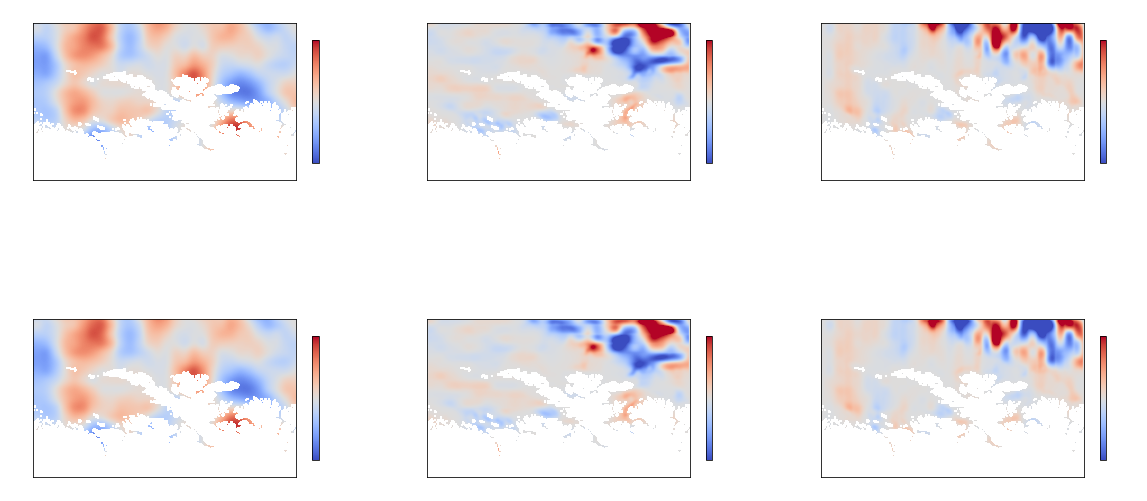

In [20]:
fig, axs = plt.subplots(2,3, figsize=(20,10))

im = axs[0,0].imshow(eta0pert - eta0, vmin=-0.05, vmax=0.05)
plt.colorbar(im, ax=axs[0,0], shrink=0.5)

im = axs[0,1].imshow(hu0pert - hu0, vmin=-100, vmax=100)
plt.colorbar(im, ax=axs[0,1], shrink=0.5)
axs[0,1].set_title("Sim parent perturbation")

im = axs[0,2].imshow(hv0pert - hv0, vmin=-100, vmax=100)
plt.colorbar(im, ax=axs[0,2], shrink=0.5)

im = axs[1,0].imshow(slave_eta_pert - slave_eta, vmin=-0.05, vmax=0.05)
plt.colorbar(im, ax=axs[1,0], shrink=0.5)

im = axs[1,1].imshow(slave_hu_pert - slave_hu, vmin=-100, vmax=100)
plt.colorbar(im, ax=axs[1,1], shrink=0.5)
axs[1,1].set_title("Slave parent perturbation")

im = axs[1,2].imshow(slave_hv_pert - slave_hv, vmin=-100, vmax=100)
plt.colorbar(im, ax=axs[1,2], shrink=0.5)

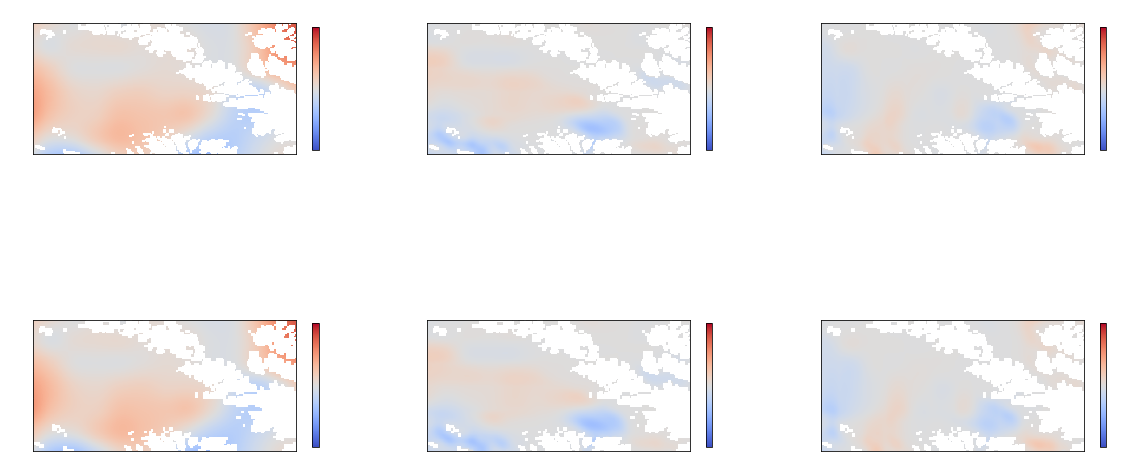

In [21]:
fig, axs = plt.subplots(2,3, figsize=(20,10))

im = axs[0,0].imshow(eta1pert - eta1, vmin=-0.05, vmax=0.05)
plt.colorbar(im, ax=axs[0,0], shrink=0.5)

im = axs[0,1].imshow(hu1pert - hu1, vmin=-100, vmax=100)
plt.colorbar(im, ax=axs[0,1], shrink=0.5)
axs[0,1].set_title("Sim child perturbation")

im = axs[0,2].imshow(hv1pert - hv1, vmin=-100, vmax=100)
plt.colorbar(im, ax=axs[0,2], shrink=0.5)


im = axs[1,0].imshow((eta0pert - eta0)[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], vmin=-0.05, vmax=0.05)
plt.colorbar(im, ax=axs[1,0], shrink=0.5)

im = axs[1,1].imshow((hu0pert - hu0)[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], vmin=-100, vmax=100)
plt.colorbar(im, ax=axs[1,1], shrink=0.5)
axs[0,1].set_title("Slave local perturbation (no child)")

im = axs[1,2].imshow((hv0pert - hv0)[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], vmin=-100, vmax=100)
plt.colorbar(im, ax=axs[1,2], shrink=0.5)

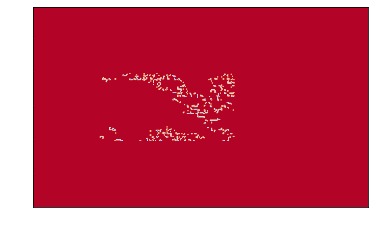

In [31]:
plt.imshow(slave_eta.mask[2:-2,2:-2] == slave_hu.mask[2:-2,2:-2])